# Classifier drift detector on CIFAR-10

### Method

The classifier-based drift detector simply tries to correctly classify instances from the reference data vs. the test set. If the classifier does not manage to significantly distinguish the reference data from the test set according to a chosen metric (defaults to the classifier accuracy), then no drift occurs. If it can, the test set is different from the reference data and drift is flagged. To leverage all the available reference and test data, stratified cross-validation can be applied and the out-of-fold predictions are used to compute the drift metric. Note that a new classifier is trained for each test set or even each fold within the test set.

### Dataset

[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60,000 32 by 32 RGB images equally distributed over 10 classes. We evaluate the drift detector on the CIFAR-10-C dataset ([Hendrycks & Dietterich, 2019](https://arxiv.org/abs/1903.12261)). The instances in
CIFAR-10-C have been corrupted and perturbed by various types of noise, blur, brightness etc. at different levels of severity, leading to a gradual decline in the classification model performance. We also check for drift against the original test set with class imbalances. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input

from alibi_detect.cd import ClassifierDrift
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

### Load data

Original CIFAR-10 data:

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)

For CIFAR-10-C, we can select from the following corruption types at 5 severity levels:

In [3]:
corruptions = corruption_types_cifar10c()
print(corruptions)

['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']


Let's pick a subset of the corruptions at corruption level 5. Each corruption type consists of perturbations on all of the original test set images.

In [4]:
corruption = ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

We split the original test set in a reference dataset and a dataset which should not be flagged as drift. We also split the corrupted data by corruption type:

In [5]:
np.random.seed(0)
n_test = X_test.shape[0]
idx = np.random.choice(n_test, size=n_test // 2, replace=False)
idx_h0 = np.delete(np.arange(n_test), idx, axis=0)
X_ref,y_ref = X_test[idx], y_test[idx]
X_h0, y_h0 = X_test[idx_h0], y_test[idx_h0]
print(X_ref.shape, X_h0.shape)

(5000, 32, 32, 3) (5000, 32, 32, 3)


In [6]:
X_c = []
n_corr = len(corruption)
for i in range(n_corr):
    X_c.append(X_corr[i * n_test:(i + 1) * n_test])

We can visualise the same instance for each corruption type:

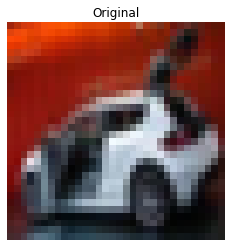

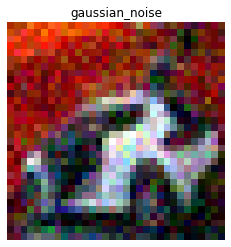

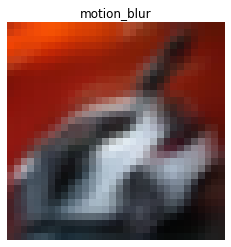

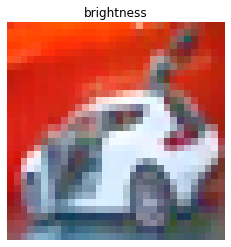

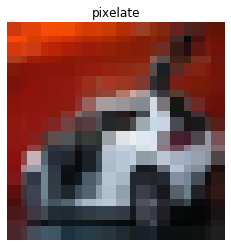

In [7]:
i = 6

n_test = X_test.shape[0]
plt.title('Original')
plt.axis('off')
plt.imshow(X_test[i])
plt.show()
for _ in range(len(corruption)):
    plt.title(corruption[_])
    plt.axis('off')
    plt.imshow(X_corr[n_test * _+ i])
    plt.show()

### Detect drift

We use a simple classification model and try to distinguish between the reference data and the corrupted test sets. Initially we'll use an accuracy threshold set at $0.55$, use $75$% of the shuffled reference and test data for training and evaluate the detector on the remaining $25$%. We only train for 1 epoch.

In [8]:
tf.random.set_seed(0)

model = tf.keras.Sequential(
  [
      Input(shape=(32, 32, 3)),
      Conv2D(8, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(16, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(32, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(2, activation='softmax')
  ]
)

cd = ClassifierDrift(threshold=.55, model=model, X_ref=X_ref, train_size=.75, epochs=1)

# we can also save/load an initialised detector
filepath = 'my_path'  # change to directory where detector is saved
save_detector(cd, filepath)
cd = load_detector(filepath)

In [9]:
preds_h0 = cd.predict(X_h0)

labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds_h0['data']['is_drift']]))

Drift? No!


As expected, no drift occurred. The accuracy of the classifier is close to random and below the threshold:

In [10]:
print(f"accuracy: {preds_h0['data']['accuracy']} -- threshold: {preds_h0['data']['threshold']}")

accuracy: 0.4864 -- threshold: 0.55


Let's now check the predictions on the corrupted data:

In [11]:
for x, c in zip(X_c, corruption):
    preds = cd.predict(x)
    print(f'Corruption type: {c}')
    print(f"Drift? {labels[preds['data']['is_drift']]}")
    print(f"Accuracy: {preds['data']['accuracy']}")
    print('')

Corruption type: gaussian_noise
Drift? Yes!
Accuracy: 0.9661333333333333

Corruption type: motion_blur
Drift? Yes!
Accuracy: 0.8621333333333333

Corruption type: brightness
Drift? Yes!
Accuracy: 0.9064

Corruption type: pixelate
Drift? Yes!
Accuracy: 0.9941333333333333



The classifier could easily distinguish the corrupted from the reference data.

### Use all the available data

So far we've only used $25$% of the data to detect the drift since $75$% is used for training purposes. At the cost of additional training time we can however leverage all the data via stratified cross-validation. We just need to set the number of folds and keep everything else the same. So for each test set `n_folds` models are trained, and the out-of-fold predictions combined for the final drift metric (in this case the accuracy):

In [12]:
cd = ClassifierDrift(threshold=.55, model=model, X_ref=X_ref, n_folds=5, epochs=1)

In [13]:
for x, c in zip(X_c, corruption):
    preds = cd.predict(x)
    print(f'Corruption type: {c}')
    print(f"Drift? {labels[preds['data']['is_drift']]}")
    print(f"Accuracy: {preds['data']['accuracy']}")
    print('')

Corruption type: gaussian_noise
Drift? Yes!
Accuracy: 0.9791333333333333

Corruption type: motion_blur
Drift? Yes!
Accuracy: 0.8912666666666667

Corruption type: brightness
Drift? Yes!
Accuracy: 0.91

Corruption type: pixelate
Drift? Yes!
Accuracy: 0.929



In [14]:
preds_h0 = cd.predict(X_h0)
print(f"Drift? {labels[preds_h0['data']['is_drift']]}")
print(f"Accuracy: {preds_h0['data']['accuracy']}")

Drift? No!
Accuracy: 0.5003


### Customize the drift metric

The drift metric can be adjusted which is very helpful in cases when there is for instance class imbalance as the test dataset sizes can vary by batch. Any function taking `y_true` and `y_pred` als input can be used as drift metric. In the following we'll use the $F1$-score as an illustration:

In [15]:
from sklearn.metrics import f1_score

def f1_adj(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return f1_score(y_true, np.round(y_pred))  # model returns soft predictions, not class labels

In [16]:
cd = ClassifierDrift(threshold=.55, model=model, X_ref=X_ref, n_folds=5, epochs=1, metric_fn=f1_adj)

In [17]:
for x, c in zip(X_c, corruption):
    preds = cd.predict(x)
    print(f'Corruption type: {c}')
    print(f"Drift? {labels[preds['data']['is_drift']]}")
    print(f"F1 score: {preds['data']['f1_adj']}")
    print('')

Corruption type: gaussian_noise
Drift? Yes!
F1 score: 0.9485769885672586

Corruption type: motion_blur
Drift? Yes!
F1 score: 0.9197636744806557

Corruption type: brightness
Drift? Yes!
F1 score: 0.9285508775294907

Corruption type: pixelate
Drift? Yes!
F1 score: 0.9874924349404881



In [18]:
preds_h0 = cd.predict(X_h0)

print('Drift? {}'.format(labels[preds_h0['data']['is_drift']]))
print(f"F1 score: {preds_h0['data']['f1_adj']}")

Drift? No!
F1 score: 0.0003999200159968007
